# LDA with Gibbs Sampling

## Import Libraries

Libraries for dataprocessing

In [1]:
import numpy as np
import spacy
spacy.load('en_core_web_sm')
from spacy.lang.en import English
import nltk
from nltk.corpus import reuters, wordnet as wn
from nltk.corpus import stopwords
from LDA import LDA_word_embed
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

Libraries for word embeddings

In [2]:
from gensim.models import Word2Vec

## Data Preprocessing

In [3]:
stops = stopwords.words("english")
# Add additional stop words
stops += [
    "a", "about", "above", "across", "after", "afterwards", "again", "against",
    "all", "almost", "alone", "along", "already", "also", "although", "always",
    "am", "among", "amongst", "amoungst", "amount", "an", "and", "another",
    "any", "anyhow", "anyone", "anything", "anyway", "anywhere", "are",
    "around", "as", "at", "back", "be", "became", "because", "become",
    "becomes", "becoming", "been", "before", "beforehand", "behind", "being",
    "below", "beside", "besides", "between", "beyond", "bill", "both",
    "bottom", "but", "by", "call", "can", "cannot", "cant", "co", "con",
    "could", "couldnt", "cry", "de", "describe", "detail", "do", "done",
    "down", "due", "during", "each", "eg", "eight", "either", "eleven", "else",
    "elsewhere", "empty", "enough", "etc", "even", "ever", "every", "everyone",
    "everything", "everywhere", "except", "few", "fifteen", "fifty", "fill",
    "find", "fire", "first", "five", "for", "former", "formerly", "forty",
    "found", "four", "from", "front", "full", "further", "get", "give", "go",
    "had", "has", "hasnt", "have", "he", "hence", "her", "here", "hereafter",
    "hereby", "herein", "hereupon", "hers", "herself", "him", "himself", "his",
    "how", "however", "hundred", "i", "ie", "if", "in", "inc", "indeed",
    "interest", "into", "is", "it", "its", "itself", "keep", "last", "latter",
    "latterly", "least", "less", "ltd", "made", "many", "may", "me",
    "meanwhile", "might", "mill", "mine", "more", "moreover", "most", "mostly",
    "move", "much", "must", "my", "myself", "name", "namely", "neither",
    "never", "nevertheless", "next", "nine", "no", "nobody", "none", "noone",
    "nor", "not", "nothing", "now", "nowhere", "of", "off", "often", "on",
    "once", "one", "only", "onto", "or", "other", "others", "otherwise", "our",
    "ours", "ourselves", "out", "over", "own", "part", "per", "perhaps",
    "please", "put", "rather", "re", "same", "see", "seem", "seemed"
]

In [4]:
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma

### Dataset 1: NLTK reuters
    a dataset of new articles, using the titles

In [5]:
# fetch titles only, 2000 docs only 
dataset = []
vocab = []

i = 0
for file_id in reuters.fileids():
    
    doc = [get_lemma(w.lower()) for w in reuters.words(file_id) \
                 if (w.isupper()) \
                 if (w.lower() not in stops) \
                 and (not w.isnumeric())]
    if doc:
        doc = [t for t in doc if len(t) > 1]
        dataset.append(doc)
        vocab += doc
        i += 1

    if i >= 2000:
        break

dataset = [[token for token in sublist if len(token) > 1] for sublist in dataset]

In [6]:
print(len(dataset))
dataset

2000


[['asian', 'exporter', 'fear', 'damage', 'japan', 'rift', 'mc', 'miti'],
 ['china', 'daily', 'say', 'vermin', 'eat', 'pct', 'grain', 'stocks'],
 ['japan',
  'revise',
  'long',
  'term',
  'energy',
  'demand',
  'downwards',
  'miti',
  'miti',
  'miti',
  'miti'],
 ['thai', 'trade', 'deficit', 'widen', 'quarter'],
 ['indonesia',
  'see',
  'cpo',
  'price',
  'rising',
  'sharply',
  'cpo',
  'fob',
  'cpo',
  'cif',
  'cpo'],
 ['australian',
  'foreign',
  'ship',
  'ban',
  'end',
  'nsw',
  'port',
  'hit',
  'nsw',
  'nsw',
  'nsw',
  'nsw'],
 ['indonesian', 'commodity', 'exchange', 'expand', 'cpo', 'fob', 'fob'],
 ['sri', 'lanka', 'get', 'usda', 'approval', 'wheat', 'price'],
 ['western',
  'mining',
  'open',
  'new',
  'gold',
  'australia',
  'wmng',
  'wmc',
  'wmc',
  'gra',
  'wmc'],
 ['sumitomo', 'bank', 'aim', 'quick', 'recovery', 'merger', 'sumi'],
 ['subroto',
  'say',
  'indonesia',
  'support',
  'tin',
  'pact',
  'extension',
  'ita',
  'ita',
  'ita'],
 ['bundesba

### Dataset 2: dataset.csv
    a dataset of research paper titles

In [7]:
parser = English()
def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

In [8]:
def tokenize_text(text):
    tokens = tokenize(text)
    tokens = [t for t in tokens if len(t) > 4]
    tokens = [t for t in tokens if t not in stops]
    tokens = [get_lemma(t) for t in tokens]
    return tokens

In [9]:
dataset2 = []
vocab2 = []
with open('dataset.csv') as f:
    for line in f:
        tokened_line = tokenize_text(line)
        vocab2 += tokened_line
        dataset2.append(tokened_line)

In [10]:
print(len(dataset2))
dataset2

2507


[['innovation',
  'database',
  'management',
  'computer',
  'science',
  'engineering'],
 ['performance', 'prime', 'field', 'multiplication'],
 ['enchant',
  'scissors',
  'scissor',
  'interface',
  'support',
  'cutting',
  'interactive',
  'fabrication'],
 ['detection',
  'channel',
  'degradation',
  'attack',
  'intermediary',
  'linear',
  'network'],
 ['pinning', 'complex', 'network', 'betweenness', 'centrality', 'strategy'],
 ['analysis', 'design', 'memoryless', 'interconnect', 'encoding', 'scheme'],
 ['dynamic', 'bluescreens'],
 ['quantitative', 'assure', 'forwarding', 'service'],
 ['automatic',
  'sanitization',
  'social',
  'network',
  'prevent',
  'inference',
  'attack'],
 ['916;&#931',
  'radar',
  'range',
  'capability',
  'human',
  'monitoring',
  'system'],
 ['architecture', 'multi', 'memory', 'system', 'operation'],
 ['base', 'service', 'customization', 'houdini'],
 ['business', 'policy', 'modeling', 'enforcement', 'database'],
 ['speed', 'linearity', 'power', '

## Preping data for LDA

### For Dataset 1

In [11]:
vocab = list(set(vocab))
word_to_ix = {w: i for i, w in enumerate(vocab)}

def seq_to_ix(seq, vocab=vocab):
    # len(vocab), which is the last index, is for the <unk> (unknown) token
    unk_idx = len(vocab)
    return np.array(list(map(lambda w: word_to_ix.get(w, unk_idx), seq)))

data = {
    "data1": list(map(seq_to_ix, dataset))
}
docs = data["data1"]

### For Dataset 2

In [12]:
vocab2 = list(set(vocab2))
word_to_ix2 = {w: i for i, w in enumerate(vocab2)}

def seq_to_ix(seq, vocab=vocab2):
    # len(vocab), which is the last index, is for the <unk> (unknown) token
    unk_idx = len(vocab)
    return np.array(list(map(lambda w: word_to_ix2.get(w, unk_idx), seq)))

data = {
    "data2": list(map(seq_to_ix, dataset2))
}
docs2 = data["data2"]

## Word Embeddings

### Dataset 1 and 2

In [13]:
model_dataset = Word2Vec(dataset, vector_size=100, window=5,min_count=1,workers=4)
model_dataset2 = Word2Vec(dataset2, vector_size=100, window=5,min_count=1,workers=4)

In [14]:
embedding_dim = 100  # As specified in your model
word_embeddings = np.zeros((len(vocab), embedding_dim))
word_embeddings2 = np.zeros((len(vocab), embedding_dim))

for i, word in enumerate(vocab):
    # Check if the word is in the model's vocabulary
    if word in model_dataset.wv:
        word_embeddings[i] = model_dataset.wv[word]
    elif word in model_dataset2.wv:
        word_embeddings2[i] = model_dataset2.wv[word]

### Normalize Word Embeddings

In [15]:
# Normalize the embeddings
normalized_word_embeddings = np.zeros_like(word_embeddings)
normalized_word_embeddings2 = np.zeros_like(word_embeddings2)

for i in range(len(vocab)):
    norm = np.linalg.norm(word_embeddings[i])
    if norm > 0:
        normalized_word_embeddings[i] = word_embeddings[i] / norm

    norm2 = np.linalg.norm(word_embeddings2[i])
    if norm2 > 0:
        normalized_word_embeddings2[i] = word_embeddings2[i] / norm2

In [16]:
word_embeddings

array([[-0.00023041, -0.00026017,  0.00790246, ..., -0.0119525 ,
         0.00777983, -0.00239242],
       [-0.00860884, -0.00632638,  0.00359047, ...,  0.0066379 ,
         0.00463261,  0.00086591],
       [-0.00872557,  0.01049589,  0.00468102, ..., -0.00455438,
         0.00367617,  0.00290756],
       ...,
       [ 0.00237965, -0.00108568,  0.0091967 , ...,  0.00084264,
        -0.00711772,  0.00469515],
       [-0.00898171,  0.00347045, -0.00532864, ..., -0.00867246,
        -0.00196352,  0.0062049 ],
       [-0.01004393, -0.00222585,  0.00056249, ..., -0.00712825,
        -0.00472697,  0.00954304]])

In [17]:
normalized_word_embeddings

array([[-0.00347464, -0.00392335,  0.11917027, ..., -0.18024547,
         0.11732099, -0.03607805],
       [-0.16174268, -0.11885988,  0.0674576 , ...,  0.12471276,
         0.08703744,  0.01626867],
       [-0.13908693,  0.1673062 ,  0.07461613, ..., -0.07259748,
         0.05859872,  0.04634696],
       ...,
       [ 0.04050225, -0.01847858,  0.15653012, ...,  0.0143419 ,
        -0.12114531,  0.07991263],
       [-0.14408995,  0.05567506, -0.08548526, ..., -0.1391288 ,
        -0.03150001,  0.0995427 ],
       [-0.19102091, -0.0423324 ,  0.01069782, ..., -0.13556889,
        -0.08989999,  0.18149456]])

## LDA with Word Embeddings

In [18]:
lda_news_embed = LDA_word_embed(docs, vocab, word_embeddings=normalized_word_embeddings,n_topic=10,random_state=1)
lda_news_embed.run_gibbs()

V: 3860
k: 10
N: [ 8  8 11  5 11 12  7  7 11  7]...
M: 2000
alpha: [1.16778425]
_eta: [0.93683206]
n_iw: dim (10, 3860)
n_di: dim (2000, 10)
assign: dim (2000, 70, 2001)

 ========== START SAMPLER ==========
Sampled 50/2000
Sampled 100/2000
Sampled 150/2000
Sampled 200/2000
Sampled 250/2000
Sampled 300/2000
Sampled 350/2000
Sampled 400/2000
Sampled 450/2000
Sampled 500/2000
Sampled 550/2000
Sampled 600/2000
Sampled 650/2000
Sampled 700/2000
Sampled 750/2000
Sampled 800/2000
Sampled 850/2000
Sampled 900/2000
Sampled 950/2000
Sampled 1000/2000
Sampled 1050/2000
Sampled 1100/2000
Sampled 1150/2000
Sampled 1200/2000
Sampled 1250/2000
Sampled 1300/2000
Sampled 1350/2000
Sampled 1400/2000
Sampled 1450/2000
Sampled 1500/2000
Sampled 1550/2000
Sampled 1600/2000
Sampled 1650/2000
Sampled 1700/2000
Sampled 1750/2000
Sampled 1800/2000
Sampled 1850/2000
Sampled 1900/2000
Sampled 1950/2000
Sampled 2000/2000


In [19]:
with open('ldanews_embed5.pkl', 'wb') as f:
        pickle.dump(lda_news_embed, f)

In [20]:
def n_most_important(beta_i,vocab,n):
    """
    find the index of the largest `n` values in a list
    """
    
    max_values = beta_i.argsort()[-n:][::-1]
    return np.array(vocab)[max_values]

In [21]:
beta,theta = lda_news_embed.sample()
i = 0
for i in range(lda_news_embed.k):
    print(f"TOPIC {i:02}: {n_most_important(beta[i],vocab,9)}")

TOPIC 00: ['oecd' 'see' 'gnp' 'imf' 'gdp' 'growth' 'acquire' 'vw' 'new']
TOPIC 01: ['ec' 'oil' 'raise' 'price' 'crude' 'ct' 'trade' 'bbl' 'posting']
TOPIC 02: ['cut' 'japan' 'aegon' 'rtz' 'see' 'bp' 'miti' 'stake' 'mpt']
TOPIC 03: ['acquisition' 'unit' 'sell' 'complete' 'lme' 'sec' 'make' 'itc' 'smc']
TOPIC 04: ['csr' 'ldp' 'etl' 'ual' 'buy' 'bid' 'set' 'acquire' 'industry']
TOPIC 05: ['qtr' 'net' '1st' 'note' 'corp' 'loss' 'ct' '2nd' '4th']
TOPIC 06: ['group' 'unit' 'stake' 'cpc' 'usx' 'jwt' 'split' 'acquire' 'dividend']
TOPIC 07: ['gaf' 'ibm' 'pct' 'usa' 'say' 'report' 'pc' 'unit' 'stake']
TOPIC 08: ['say' 'mln' 'pct' 'opec' 'dlrs' 'buy' 'bank' 'rise' 'fed']
TOPIC 09: ['usda' 'nil' 'wheat' 'ccc' 'grain' 'soybean' 'tonne' 'sell' 'crop']


In [ ]:
lda_research_embed = LDA_word_embed(docs2, vocab2, word_embeddings=normalized_word_embeddings2,n_topic=10,random_state=1)
lda_research_embed.run_gibbs()

In [ ]:
with open('ldaresearch_embed5.pkl', 'wb') as f:
        pickle.dump(lda_research_embed, f)

In [ ]:
beta2,theta2 = lda_research_embed.sample()
i = 0
for i in range(lda_research_embed.k):
    print(f"TOPIC {i:02}: {n_most_important(beta2[i],vocab2,9)}")

TOPIC 00: ['base' 'system' 'design' 'query' 'model' 'approach' 'semantic'
 'information' 'database']
TOPIC 01: ['system' 'method' 'using' 'power' 'base' 'search' 'modeling' 'scalable'
 'efficient']
TOPIC 02: ['network' 'wireless' 'sensor' 'control' 'multi' 'power' 'route'
 'algorithm' 'distribute']
TOPIC 03: ['analysis' 'video' 'image' 'system' 'database' 'aware' 'approach'
 'application' 'adaptive']
TOPIC 04: ['base' 'model' 'structure' 'using' 'receiver' 'digital' 'architecture'
 'database' 'cloud']
TOPIC 05: ['algorithm' 'base' 'large' 'using' 'voltage' 'filter' 'network'
 'continuous' 'search']
TOPIC 06: ['algorithm' 'application' 'query' 'system' 'delta' 'model' 'analysis'
 'amplifier' 'estimation']
TOPIC 07: ['base' 'system' 'using' 'detection' 'application' 'model' 'database'
 'filter' 'image']
TOPIC 08: ['using' 'efficient' 'design' 'power' 'query' 'base' 'optimization'
 'architecture' 'scheme']
TOPIC 09: ['base' 'design' 'system' 'circuit' 'large' 'query' 'network' 'filter'
 '

### Graphing

#### Dataset 1

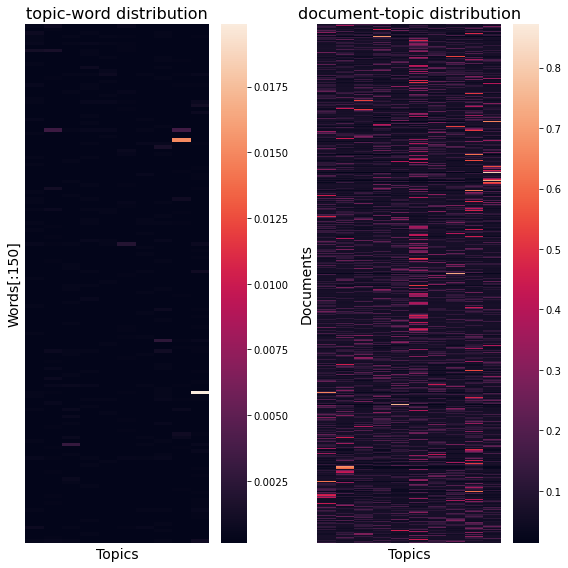

In [23]:
plt.figure(figsize=(8,8))
plt.subplot(121)
n_plot_words = 150
sns.heatmap(beta.T[:n_plot_words], xticklabels=[], yticklabels=[])
plt.xlabel("Topics", fontsize=14)
plt.ylabel(f"Words[:{n_plot_words}]", fontsize=14)
plt.title("topic-word distribution", fontsize=16)

plt.subplot(122)
sns.heatmap(theta, xticklabels=[], yticklabels=[])
plt.xlabel("Topics", fontsize=14)
plt.ylabel("Documents", fontsize=14)
plt.title("document-topic distribution", fontsize=16)

plt.tight_layout()

#### Dataset 2

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(121)
n_plot_words = 150
sns.heatmap(beta2.T[:n_plot_words], xticklabels=[], yticklabels=[])
plt.xlabel("Topics", fontsize=14)
plt.ylabel(f"Words[:{n_plot_words}]", fontsize=14)
plt.title("topic-word distribution", fontsize=16)

plt.subplot(122)
sns.heatmap(theta2, xticklabels=[], yticklabels=[])
plt.xlabel("Topics", fontsize=14)
plt.ylabel("Documents", fontsize=14)
plt.title("document-topic distribution", fontsize=16)

plt.tight_layout()

## Label Generation

### Dataset 1: Wikipedia

In [ ]:
topic_00_1 = ['opec', 'gaf', 'stake', 'see', 'buy', 'pct', 'complete', 'year', 'south']
topic_00_w_labels_1 = []

topic_01_1 = ['acquisition', 'year', 'acquire', 'talks', 'miti', 'ncr', 'gte', 'industry', 'price']
topic_01_w_labels_1 = ['barcode']

topic_02_1 = ['csr', 'etl', 'ual', 'sec', 'smc', 'bid', 'buy', 'see', 'trade']
topic_02_w_labels_1 = []

topic_03_1 = ['ec', 'trade', 'ldp', 'gatt', 'tender', 'japan', 'tax', 'cut', 'rtz']
topic_03_w_labels_1 = []

topic_04_1 = ['say', 'mln', 'pct', 'dlrs', 'rise', 'fed', 'bank', 'share', 'rate']
topic_04_w_labels_1 = []

topic_05_1 = ['qtr', 'net', '1st', 'note', 'corp', 'loss', 'ct', '2nd', 'shr']
topic_05_w_labels_1 = []

topic_06_1 = ['usda', 'nil', 'wheat', 'grain', 'ccc', 'soybean', 'tonne', 'report', 'corn']
topic_06_w_labels_1 = []

topic_07_1 = ['oecd', 'gnp', 'imf', 'ibm', 'gdp', 'aegon', 'see', 'zccm', 'growth']
topic_07_w_labels_1 = []

topic_08_1 = ['oil', 'raise', 'price', 'crude', 'ct', 'bbl', 'posting', 'dlrs', 'lme']
topic_08_w_labels_1 = []

topic_09_1 = ['unit', 'sell', 'group', 'buy', 'cpc', 'see', 'profit', 'dividend', 'merger']
topic_09_w_labels_1 = [['canadian', 'pacific', 'railway'], ['economy', 'china']]

### Dataset 1: ChatGPT Labels

In [ ]:
topic_00_c_labels_1 = ['opec', 'investments', 'stakes', 'observations', 'acquisitions', 'percentages', 'completions', 'years', 'regions']

topic_01_c_labels_1 = ['acquisitions', 'years', 'negotiations', 'discussions', 'industries', 'prices', 'corporate', 'strategies', 'valuations']

topic_02_c_labels_1 = ['bids', 'negotiations', 'aviation', 'securities', 'offers', 'acquisitions', 'trades', 'observations', 'markets']

topic_03_c_labels_1 = ['trade', 'negotiations', 'policies', 'agreements', 'tenders', 'taxation', 'cuts', 'international', 'economics']

topic_04_c_labels_1 = ['economics', 'millions', 'percentages', 'dollars', 'rises', 'banking', 'shares', 'rates', 'financials']

topic_05_c_labels_1 = ['quarterly', 'net', 'reports', 'notes', 'corporates', 'losses', 'statements', 'earnings', 'shares']

topic_06_c_labels_1 = ['agriculture', 'reports', 'wheat', 'grains', 'soybeans', 'tons', 'analyses', 'crops', 'corn']

topic_07_c_labels_1 = ['economics', 'gnp', 'imf', 'technology', 'gdp', 'companies', 'observations', 'growth', 'indicators']

topic_08_c_labels_1 = ['oil', 'increases', 'prices', 'crude', 'costs', 'barrels', 'postings', 'dollars', 'metals']

topic_09_c_labels_1 = ['sales', 'divestitures', 'groups', 'acquisitions', 'industrials', 'observations', 'profits', 'dividends', 'mergers']


### Dataset 2: Wikipedia

In [ ]:
topic_00_2 = ['base', 'system', 'design', 'query', 'model', 'approach', 'semantic', 'information', 'database']
topic_00_w_labels_2 = topic_00_w_labels_2 = ['database', ['database', 'design'], ['semantic', 'query'], ['graph', 'database'], ['database', 'model'], ['federated', 'database', 'system'], ['entity-relationship', 'model'], ['domain-driven', 'design'], ['relational', 'model']]

topic_01_2 = ['system', 'method', 'using', 'power', 'base', 'search', 'modeling', 'scalable', 'efficient']
topic_01_w_labels_2 = [['binary', 'search', 'algorithm'], ['monte', 'carlo', 'method'], ['kardashev', 'scale'], ['large', 'language', 'model'], ['reinforcement', 'learning'], ['recommender', 'system'], ['neural', 'architecture', 'search'], ['web', 'crawler'], ['artificial', 'intelligence']]

topic_02_2 = ['network', 'wireless', 'sensor', 'control', 'multi', 'power', 'route', 'algorithm', 'distribute']
topic_02_w_labels_2 = [['wireless', 'sensor', 'network'], ['wireless', 'mesh', 'network'], ['wireless', 'ad', 'hoc', 'network'], ['optimized', 'link', 'state', 'routing', 'protocol'], ['network', 'topology'], ['computer', 'network'], ['ant', 'colony', 'optimization', 'algorithms'], ['internet', 'things'], ['backpressure', 'routing']]

topic_03_2 = ['analysis', 'video', 'image', 'system', 'database', 'aware', 'approach', 'application', 'adaptive']
topic_03_w_labels_2 = ['embedded', 'system', ['applications', 'artificial', 'intelligence'], ['automatic', 'summarization'], ['convolutional', 'neural', 'network'], ['machine', 'learning'], ['medical', 'image', 'computing'], ['total', 'information', 'awareness'], ['list', 'datasets',  'machine-learning'], ['artificial', 'intelligence']]

topic_04_2 = ['base', 'model', 'structure', 'using', 'receiver', 'digital', 'architecture', 'database', 'cloud']
topic_04_w_labels_2 = [['cloud', 'computing', 'security'], 'rest', ['microsoft','azure'], ['digital','revolution'], 'lidar', ['glossary', 'computer', 'science'], ['list', 'computing', 'IT', 'abbreviations'], ['computer', 'network'], ['geographic', 'information', 'system']]

topic_05_2 = ['algorithm', 'base', 'large', 'using', 'voltage', 'filter', 'network', 'continuous', 'search']
topic_05_w_labels_2 = [['radio', 'receiver'],['affective','computing'],['power','network','design'],['digital','image','processing'],'electroencephalography',['big','data'],['list', 'MOSFET','applications'],['applications','artifical','intelligence'],'radar']

topic_06_2 = ['algorithm', 'application', 'query', 'system', 'delta', 'model', 'analysis', 'amplifier', 'estimation']
topic_06_w_labels_2 = ['transformer']

topic_07_2 = ['base', 'system', 'using', 'detection', 'application', 'model', 'database', 'filter', 'image']
topic_07_w_labels_2 = [['content-based', 'image', 'retrieval'], ['computer', 'vision'], ['kalman', 'filter'], ['image', 'segmentation'], 'lidar', ['convolutional', 'neural', 'network'], ['facial', 'recognition', 'system'], ['digital', 'image', 'processing'], ['image', 'scanner']]

topic_08_2 = ['using', 'efficient', 'design', 'power', 'query', 'base', 'optimization', 'architecture', 'scheme']
topic_08_w_labels_2 = [['database', 'design'], 'transformer', 'monetdb', ['column-oriented', 'dbms'], ['large', 'language', 'model'], ['list', 'algorithms'], ['learning','rank'], ['load', 'balancing'], ['adaptive', 'web', 'design']]

topic_09_2 = ['base', 'design', 'system', 'circuit', 'large', 'query', 'network', 'filter', 'management']
topic_09_w_labels_2 = [['database', 'design'], ['artificial', 'neural', 'network'], ['list', 'computing', 'abbreviations'], ['glossary', 'artificial', 'intelligence'], ['deep', 'learning'], ['computer','security'],['rete','algorithm'],['list','tcp','udp','port','numbers'], ['in-memory','processing']]



### Dataset 2: ChatGPT Labels

In [ ]:
topic_00_c_labels_2 = ['databases', 'systems', 'designs', 'models', 'queries', 'semantics', 'approaches', 'information', 'architecture']

topic_01_c_labels_2 = ['methods', 'power', 'efficiency', 'scalability', 'systems', 'modeling', 'searches', 'usage', 'bases']

topic_02_c_labels_2 = ['networks', 'wireless', 'sensors', 'control', 'routing', 'algorithms', 'multi-network', 'power', 'distribution']

topic_03_c_labels_2 = ['analysis', 'video', 'imaging', 'databases', 'adaptivity', 'systems', 'applications', 'awareness', 'approaches']

topic_04_c_labels_2 = ['foundations', 'models', 'structures', 'usage', 'receivers', 'digital', 'architecture', 'databases', 'cloud']

topic_05_c_labels_2 = ['algorithms', 'bases', 'magnitude', 'utility', 'voltage', 'filters', 'networks', 'continuity', 'searches']

topic_06_c_labels_2 = ['algorithms', 'applications', 'queries', 'systems', 'delta', 'models', 'analysis', 'amplification', 'estimations']

topic_07_c_labels_2 = ['foundations', 'systems', 'usage', 'detection', 'applications', 'models', 'databases', 'filters', 'imaging']

topic_08_c_labels_2 = ['efficiency', 'designs', 'optimization', 'power', 'queries', 'architecture', 'schemes', 'usage', 'bases']

topic_09_c_labels_2 = ['foundations', 'designs', 'systems', 'circuits', 'scale', 'queries', 'networks', 'filters', 'management']

### Candidate Labels and Label Score Generation

In [ ]:
import gensim.downloader
import inflect
vectors = gensim.downloader.load('fasttext-wiki-news-subwords-300')

In [ ]:
def is_plural_of(word, plural):
    p = inflect.engine()
    return p.plural(word) == plural or p.singular_noun(plural) == word
def label_scores(labels,cluster):
    # Calculate label scores
    label_scores = {}
    for label in labels:
        label_list = [label] if isinstance(label, str) else label
        if all(word in vectors for word in label_list):
            similarities = []
            for term in cluster:
                if term in vectors and term != label:
                    if len(label_list) == 1:
                        if not is_plural_of(label, term):
                            sim = vectors.n_similarity(label, term)
                            similarities.append(sim)
                    else:
                        sim = vectors.n_similarity(label, term)
                        similarities.append(sim)
            if similarities:  # Check if there are similarities calculated
                label_scores[str(label)] = sum(similarities) / len(similarities)
    sorted_labels = sorted(label_scores.items(), key=lambda x: x[1], reverse=True)
    return sorted_labels

#### Dataset 1 Labels

In [ ]:
labels_00_1 = topic_00_1[:5] + topic_00_w_labels_1 + topic_00_c_labels_1
label_00_1_scores = label_scores(labels_00_1,topic_00_1)
print(topic_00_1)
print(labels_00_1)
print(f"Dataset 1: TOPIC 00 top scoring label: {label_00_1_scores[0]}")

['opec', 'gaf', 'stake', 'see', 'buy', 'pct', 'complete', 'year', 'south']
['opec', 'gaf', 'stake', 'see', 'buy', 'opec', 'investments', 'stakes', 'observations', 'acquisitions', 'percentages', 'completions', 'years', 'regions']
Dataset 1: TOPIC 00 top scoring label: ('percentages', 0.9653268059094747)


In [ ]:
labels_01_1 = topic_01_1[:5] + topic_01_w_labels_1 + topic_01_c_labels_1
label_01_1_scores = label_scores(labels_01_1,topic_01_1)
print(topic_01_1)
print(labels_01_1)
print(f"Dataset 1: TOPIC 01 top scoring label: {label_01_1_scores[0]}")

['acquisition', 'year', 'acquire', 'talks', 'miti', 'ncr', 'gte', 'industry', 'price']
['acquisition', 'year', 'acquire', 'talks', 'miti', 'barcode', 'acquisitions', 'years', 'negotiations', 'discussions', 'industries', 'prices', 'corporate', 'strategies', 'valuations']
Dataset 1: TOPIC 01 top scoring label: ('negotiations', 0.9670576784345839)


In [ ]:
labels_02_1 = topic_02_1[:5] + topic_02_w_labels_1 + topic_02_c_labels_1
label_02_1_scores = label_scores(labels_02_1,topic_02_1)
print(topic_02_1)
print(labels_02_1)
print(f"Dataset 1: TOPIC 02 top scoring label: {label_02_1_scores[0]}")

['csr', 'etl', 'ual', 'sec', 'smc', 'bid', 'buy', 'see', 'trade']
['csr', 'etl', 'ual', 'sec', 'smc', 'bids', 'negotiations', 'aviation', 'securities', 'offers', 'acquisitions', 'trades', 'observations', 'markets']
Dataset 1: TOPIC 02 top scoring label: ('securities', 0.9567103758454323)


In [ ]:
labels_03_1 = topic_03_1[:5] + topic_01_w_labels_1 + topic_01_c_labels_1
label_03_1_scores = label_scores(labels_03_1,topic_03_1)
print(topic_03_1)
print(labels_03_1)
print(f"Dataset 1: TOPIC 03 top scoring label: {label_03_1_scores[0]}")

['ec', 'trade', 'ldp', 'gatt', 'tender', 'japan', 'tax', 'cut', 'rtz']
['ec', 'trade', 'ldp', 'gatt', 'tender', 'barcode', 'acquisitions', 'years', 'negotiations', 'discussions', 'industries', 'prices', 'corporate', 'strategies', 'valuations']
Dataset 1: TOPIC 03 top scoring label: ('corporate', 0.9542363626616341)


In [ ]:
labels_04_1 = topic_04_1[:5] + topic_04_w_labels_1 + topic_04_c_labels_1
label_04_1_scores = label_scores(labels_04_1,topic_04_1)
print(topic_04_1)
print(labels_04_1)
print(f"Dataset 1: TOPIC 04 top scoring label: {label_04_1_scores[0]}")

['say', 'mln', 'pct', 'dlrs', 'rise', 'fed', 'bank', 'share', 'rate']
['say', 'mln', 'pct', 'dlrs', 'rise', 'economics', 'millions', 'percentages', 'dollars', 'rises', 'banking', 'shares', 'rates', 'financials']
Dataset 1: TOPIC 04 top scoring label: ('percentages', 0.961853908167945)


In [ ]:
labels_05_1 = topic_05_1[:5] + topic_05_w_labels_1 + topic_05_c_labels_1
label_05_1_scores = label_scores(labels_05_1,topic_05_1)
print(topic_05_1)
print(labels_05_1)
print(f"Dataset 1: TOPIC 05 top scoring label: {label_05_1_scores[0]}")

['qtr', 'net', '1st', 'note', 'corp', 'loss', 'ct', '2nd', 'shr']
['qtr', 'net', '1st', 'note', 'corp', 'quarterly', 'net', 'reports', 'notes', 'corporates', 'losses', 'statements', 'earnings', 'shares']
Dataset 1: TOPIC 05 top scoring label: ('reports', 0.9552252292633057)


In [ ]:
labels_06_1 = topic_06_1[:5] + topic_06_w_labels_1 + topic_06_c_labels_1
label_06_1_scores = label_scores(labels_06_1,topic_06_1)
print(topic_06_1)
print(labels_06_1)
print(f"Dataset 1: TOPIC 06 top scoring label: {label_06_1_scores[0]}")

['usda', 'nil', 'wheat', 'grain', 'ccc', 'soybean', 'tonne', 'report', 'corn']
['usda', 'nil', 'wheat', 'grain', 'ccc', 'agriculture', 'reports', 'wheat', 'grains', 'soybeans', 'tons', 'analyses', 'crops', 'corn']
Dataset 1: TOPIC 06 top scoring label: ('agriculture', 0.955776227845086)


In [ ]:
labels_07_1 = topic_07_1[:5] + topic_07_w_labels_1 + topic_07_c_labels_1
label_07_1_scores = label_scores(labels_07_1,topic_07_1)
print(topic_07_1)
print(labels_07_1)
print(f"Dataset 1: TOPIC 07 top scoring label: {label_07_1_scores[0]}")

['oecd', 'gnp', 'imf', 'ibm', 'gdp', 'aegon', 'see', 'zccm', 'growth']
['oecd', 'gnp', 'imf', 'ibm', 'gdp', 'economics', 'gnp', 'imf', 'technology', 'gdp', 'companies', 'observations', 'growth', 'indicators']
Dataset 1: TOPIC 07 top scoring label: ('economics', 0.9561443229516348)


In [ ]:
labels_08_1 = topic_08_1[:5] + topic_08_w_labels_1 + topic_08_c_labels_1
label_08_1_scores = label_scores(labels_08_1,topic_08_1)
print(topic_08_1)
print(labels_08_1)
print(f"Dataset 1: TOPIC 08 top scoring label: {label_08_1_scores[0]}")

['oil', 'raise', 'price', 'crude', 'ct', 'bbl', 'posting', 'dlrs', 'lme']
['oil', 'raise', 'price', 'crude', 'ct', 'oil', 'increases', 'prices', 'crude', 'costs', 'barrels', 'postings', 'dollars', 'metals']
Dataset 1: TOPIC 08 top scoring label: ('barrels', 0.9599662688043382)


In [ ]:
labels_09_1 = topic_09_1[:5] + topic_09_w_labels_1 + topic_09_c_labels_1
label_09_1_scores = label_scores(labels_09_1,topic_09_1)
print(topic_09_1)
print(labels_09_1)
print(f"Dataset 1: TOPIC 09 top scoring label: {label_09_1_scores[0]}")

['unit', 'sell', 'group', 'buy', 'cpc', 'see', 'profit', 'dividend', 'merger']
['unit', 'sell', 'group', 'buy', 'cpc', ['canadian', 'pacific', 'railway'], ['economy', 'china'], 'sales', 'divestitures', 'groups', 'acquisitions', 'industrials', 'observations', 'profits', 'dividends', 'mergers']
Dataset 1: TOPIC 09 top scoring label: ('observations', 0.9552036788728502)


#### Dataset 2 Labels

In [ ]:
labels_00_2= topic_00_2[:5] + topic_00_w_labels_2 + topic_00_c_labels_2
label_00_2_scores = label_scores(labels_00_2,topic_00_2)
print(topic_00_2)
print(labels_00_2)
print(f"Dataset 2: TOPIC 00 top scoring label: {label_00_2_scores[0]}")

['base', 'system', 'design', 'query', 'model', 'approach', 'semantic', 'information', 'database']
['base', 'system', 'design', 'query', 'model', 'database', ['database', 'design'], ['semantic', 'query'], ['graph', 'database'], ['database', 'model'], ['federated', 'database', 'system'], ['entity-relationship', 'model'], ['domain-driven', 'design'], ['relational', 'model'], 'databases', 'systems', 'designs', 'models', 'queries', 'semantics', 'approaches', 'information', 'architecture']
Dataset 2: TOPIC 00 top scoring label: ('semantics', 0.9644683450460434)


In [ ]:
labels_01_2 = topic_01_2[:5] + topic_02_w_labels_2 + topic_01_c_labels_2
label_01_2_scores = label_scores(labels_01_2,topic_01_2)
print(topic_01_2)
print(labels_01_2)
print(f"Dataset 2: TOPIC 01 top scoring label: {label_01_2_scores[0]}")

['system', 'method', 'using', 'power', 'base', 'search', 'modeling', 'scalable', 'efficient']
['system', 'method', 'using', 'power', 'base', ['wireless', 'sensor', 'network'], ['wireless', 'mesh', 'network'], ['wireless', 'ad', 'hoc', 'network'], ['optimized', 'link', 'state', 'routing', 'protocol'], ['network', 'topology'], ['computer', 'network'], ['ant', 'colony', 'optimization', 'algorithms'], ['internet', 'things'], ['backpressure', 'routing'], 'methods', 'power', 'efficiency', 'scalability', 'systems', 'modeling', 'searches', 'usage', 'bases']
Dataset 2: TOPIC 01 top scoring label: ('searches', 0.9674995169043541)


In [ ]:
labels_02_2 = topic_02_2[:5] + topic_02_w_labels_2 + topic_02_c_labels_2
label_02_2_scores = label_scores(labels_02_2,topic_02_2)
print(topic_02_2)
print(labels_02_2)
print(f"Dataset 2: TOPIC 02 top scoring label: {label_02_2_scores[0]}")

['network', 'wireless', 'sensor', 'control', 'multi', 'power', 'route', 'algorithm', 'distribute']
['network', 'wireless', 'sensor', 'control', 'multi', ['wireless', 'sensor', 'network'], ['wireless', 'mesh', 'network'], ['wireless', 'ad', 'hoc', 'network'], ['optimized', 'link', 'state', 'routing', 'protocol'], ['network', 'topology'], ['computer', 'network'], ['ant', 'colony', 'optimization', 'algorithms'], ['internet', 'things'], ['backpressure', 'routing'], 'networks', 'wireless', 'sensors', 'control', 'routing', 'algorithms', 'multi-network', 'power', 'distribution']
Dataset 2: TOPIC 02 top scoring label: ('multi-network', 0.980114307668474)


In [ ]:
labels_03_2 = topic_03_2[:5] + topic_01_w_labels_2 + topic_01_c_labels_2
label_03_2_scores = label_scores(labels_03_2,topic_03_2)
print(topic_03_2)
print(labels_03_2)
print(f"Dataset 2: TOPIC 03 top scoring label: {label_03_2_scores[0]}")

['analysis', 'video', 'image', 'system', 'database', 'aware', 'approach', 'application', 'adaptive']
['analysis', 'video', 'image', 'system', 'database', ['binary', 'search', 'algorithm'], ['monte', 'carlo', 'method'], ['kardashev', 'scale'], ['large', 'language', 'model'], ['reinforcement', 'learning'], ['recommender', 'system'], ['neural', 'architecture', 'search'], ['web', 'crawler'], ['artificial', 'intelligence'], 'methods', 'power', 'efficiency', 'scalability', 'systems', 'modeling', 'searches', 'usage', 'bases']
Dataset 2: TOPIC 03 top scoring label: ('scalability', 0.968350715107388)


In [ ]:
labels_04_2 = topic_04_2[:5] + topic_04_w_labels_2 + topic_04_c_labels_2
label_04_2_scores = label_scores(labels_04_2,topic_04_2)
print(topic_04_2)
print(labels_04_2)
print(f"Dataset 2: TOPIC 04 top scoring label: {label_04_2_scores[0]}")

['base', 'model', 'structure', 'using', 'receiver', 'digital', 'architecture', 'database', 'cloud']
['base', 'model', 'structure', 'using', 'receiver', ['cloud', 'computing', 'security'], 'rest', ['microsoft', 'azure'], ['digital', 'revolution'], 'lidar', ['glossary', 'computer', 'science'], ['list', 'computing', 'IT', 'abbreviations'], ['computer', 'network'], ['geographic', 'information', 'system'], 'foundations', 'models', 'structures', 'usage', 'receivers', 'digital', 'architecture', 'databases', 'cloud']
Dataset 2: TOPIC 04 top scoring label: ('foundations', 0.970944795343611)


In [ ]:
labels_05_2 = topic_05_2[:5] + topic_05_w_labels_2 + topic_05_c_labels_2
label_05_2_scores = label_scores(labels_05_2,topic_05_2)
print(topic_05_2)
print(labels_05_2)
print(f"Dataset 2: TOPIC 05 top scoring label: {label_05_2_scores[0]}")

['algorithm', 'base', 'large', 'using', 'voltage', 'filter', 'network', 'continuous', 'search']
['algorithm', 'base', 'large', 'using', 'voltage', ['radio', 'receiver'], ['affective', 'computing'], ['power', 'network', 'design'], ['digital', 'image', 'processing'], 'electroencephalography', ['big', 'data'], ['list', 'MOSFET', 'applications'], ['applications', 'artifical', 'intelligence'], 'radar', 'algorithms', 'bases', 'magnitude', 'utility', 'voltage', 'filters', 'networks', 'continuity', 'searches']
Dataset 2: TOPIC 05 top scoring label: ('electroencephalography', 0.9769425789515177)


In [ ]:
labels_06_2 = topic_06_2[:5] + topic_06_w_labels_2 + topic_06_c_labels_2
label_06_2_scores = label_scores(labels_06_2,topic_06_2)
print(topic_06_2)
print(labels_06_2)
print(f"Dataset 2: TOPIC 06 top scoring label: {label_06_2_scores[0]}")

['algorithm', 'application', 'query', 'system', 'delta', 'model', 'analysis', 'amplifier', 'estimation']
['algorithm', 'application', 'query', 'system', 'delta', 'transformer', 'algorithms', 'applications', 'queries', 'systems', 'delta', 'models', 'analysis', 'amplification', 'estimations']
Dataset 2: TOPIC 06 top scoring label: ('transformer', 0.9718369709120857)


In [ ]:
labels_07_2 = topic_07_2[:5] + topic_07_w_labels_2 + topic_07_c_labels_2
label_07_2_scores = label_scores(labels_07_2,topic_07_2)
print(topic_07_2)
print(labels_07_2)
print(f"Dataset 2: TOPIC 07 top scoring label: {label_07_2_scores[0]}")

['base', 'system', 'using', 'detection', 'application', 'model', 'database', 'filter', 'image']
['base', 'system', 'using', 'detection', 'application', ['content-based', 'image', 'retrieval'], ['computer', 'vision'], ['kalman', 'filter'], ['image', 'segmentation'], 'lidar', ['convolutional', 'neural', 'network'], ['facial', 'recognition', 'system'], ['digital', 'image', 'processing'], ['image', 'scanner'], 'foundations', 'systems', 'usage', 'detection', 'applications', 'models', 'databases', 'filters', 'imaging']
Dataset 2: TOPIC 07 top scoring label: ('foundations', 0.9690825608041551)


In [ ]:
labels_08_2 = topic_08_2[:5] + topic_08_w_labels_2 + topic_08_c_labels_2
label_08_2_scores = label_scores(labels_08_2,topic_08_2)
print(topic_08_2)
print(labels_08_2)
print(f"Dataset 2: TOPIC 08 top scoring label: {label_08_2_scores[0]}")

['using', 'efficient', 'design', 'power', 'query', 'base', 'optimization', 'architecture', 'scheme']
['using', 'efficient', 'design', 'power', 'query', ['database', 'design'], 'transformer', 'monetdb', ['column-oriented', 'dbms'], ['large', 'language', 'model'], ['list', 'algorithms'], ['learning', 'rank'], ['load', 'balancing'], ['adaptive', 'web', 'design'], 'efficiency', 'designs', 'optimization', 'power', 'queries', 'architecture', 'schemes', 'usage', 'bases']
Dataset 2: TOPIC 08 top scoring label: ('transformer', 0.971862773100535)


In [ ]:
labels_09_2 = topic_09_2[:5] + topic_09_w_labels_2 + topic_09_c_labels_2
label_09_2_scores = label_scores(labels_09_2,topic_09_2)
print(topic_09_2)
print(labels_09_2)
print(f"Dataset 2: TOPIC 09 top scoring label: {label_09_2_scores[0]}")

['base', 'design', 'system', 'circuit', 'large', 'query', 'network', 'filter', 'management']
['base', 'design', 'system', 'circuit', 'large', ['database', 'design'], ['artificial', 'neural', 'network'], ['list', 'computing', 'abbreviations'], ['glossary', 'artificial', 'intelligence'], ['deep', 'learning'], ['computer', 'security'], ['rete', 'algorithm'], ['list', 'tcp', 'udp', 'port', 'numbers'], ['in-memory', 'processing'], 'foundations', 'designs', 'systems', 'circuits', 'scale', 'queries', 'networks', 'filters', 'management']
Dataset 2: TOPIC 09 top scoring label: ('foundations', 0.9687220652898153)
